In [14]:
# Roll Nos : 23B0977 (Keyaan Kartikeya Rajesh), 23B1052 (Ramachandran S), 23B1085 (Harith S)
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def clean_data(data, method):
    data.copy()
    data = data.dropna(subset=['vehicle_no'])

    vehicle_status = {}
    valid_rows = []

    for index, row in data.iterrows():
        vehicle_id = row['vehicle_no']
        camera_id = row['camera_id']
        last_action = vehicle_status.get(vehicle_id)

        if method == 'deletion':
            # if it's an exit without an entry, or an exit followed by an exit
            if camera_id == 2 and (last_action is None or last_action == 'exit'):
                continue
            # if it's an entry followed by an entry
            if camera_id == 1 and last_action == 'entry':
                continue

        if method == 'LOCF':
            # if it's exit without an entry, change the exit to an entry
            if camera_id == 2 and (last_action is None or last_action == 'exit'):
                row['camera_id'] = 1
            # if it's enter followed by an entry, change it to an exit
            if camera_id == 1 and last_action == 'entry':
                row['camera_id'] = 2

        valid_rows.append(row)
        vehicle_status[vehicle_id] = 'entry' if camera_id == 1 else 'exit'

    return pd.DataFrame(valid_rows)

In [16]:
def mase(actual, forecast, train_data):
    naive_forecast = train_data.shift(1).dropna()
    mae_naive = mean_absolute_error(train_data[1:], naive_forecast)
    return mean_absolute_error(actual, forecast) / mae_naive

In [17]:
def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

In [18]:
def report_errors(test_data, forecast, train_data):
    mase_value = mase(test_data, forecast, train_data)
    mape_value = mape(test_data, forecast)
    return mase_value, mape_value

In [19]:
def calculate_parking_times(data, method='deletion'):
    cleaned_data = data

    vehicle_entries = {}
    parking_durations = []

    cleaned_data = cleaned_data.sort_values('timestamp')

    for _, row in cleaned_data.iterrows():
        vehicle_id = row['vehicle_no']
        timestamp = row['timestamp']
        camera_id = row['camera_id']

        if camera_id == 1:
            vehicle_entries[vehicle_id] = timestamp
        elif camera_id == 2 and vehicle_id in vehicle_entries:
            entry_time = vehicle_entries[vehicle_id]
            duration = (timestamp - entry_time).total_seconds() / 60

            parking_durations.append(
                {'date': timestamp.date(), 'duration': duration})

            del vehicle_entries[vehicle_id]

    durations_df = pd.DataFrame(parking_durations)

    daily_avg_duration = durations_df.groupby('date')['duration'].mean()
    daily_avg_duration.index = pd.to_datetime(daily_avg_duration.index)
    daily_avg_duration = daily_avg_duration.asfreq('D')

    return daily_avg_duration

In [20]:
def forecast_total(data, method):
    data = data.copy()
    data = clean_data(data, method)

    data = data[data['camera_id'] == 1].groupby(data['timestamp'].dt.date)['vehicle_no'].size()
    data.index = pd.to_datetime(data.index)
    data = data.asfreq('D')

    train_data = data[:-7]
    test_data = data[-7:]

    ets_model = ExponentialSmoothing(
        train_data,
        seasonal='add',
        seasonal_periods=7,
        trend='add'
    )
    ets_fitted = ets_model.fit()
    ets_forecast = ets_fitted.forecast(steps=7)

    plt.plot(train_data.index, train_data, label = 'Training Data', color = 'blue')
    plt.plot(test_data.index, test_data, label = 'Testing Data', color = 'green')
    plt.plot(ets_forecast.index, ets_forecast, label = 'ETS Forecast', linestyle = '--', color = 'orange')
    plt.title('Total Vehicles Entering on a Day')
    plt.gca().get_xaxis().set_visible(False)
    plt.legend()
    plt.show()
    plt.close()

    print(f'\nETS Forecast (Outlier Smoothing Method: {method})\n')
    print(ets_forecast)
    print()

    ets_mase, ets_mape = report_errors(test_data, ets_forecast, train_data)
    print(f'ETS MASE: {ets_mase:.3f}')
    print(f'ETS MAPE: {ets_mape:.3f}\n')

In [21]:
def forecast_avg(data, method):
    data = data.copy()
    data = clean_data(data, method)

    data = calculate_parking_times(data, method)

    train_data = data[:-7]
    test_data = data[-7:]

    model = auto_arima(train_data, seasonal=True, m=7, error_action='ignore', suppress_warnings=True, stepwise=True)

    sarima_forecast, conf_int = model.predict(n_periods=7, return_conf_int=True)

    plt.plot(train_data.index, train_data, label = 'Training Data', color = 'blue')
    plt.plot(test_data.index, test_data, label = 'Testing Data', color = 'green')
    plt.plot(sarima_forecast.index, sarima_forecast, label = 'SARIMA Forecast', linestyle = '--', color = 'orange')
    plt.title('Avg time spent (in mins) by a vehicles on a Day')
    plt.gca().get_xaxis().set_visible(False)
    plt.legend()
    plt.show()
    plt.close()

    print(f'\nSARIMA Forecast (Outlier Smoothing Method: {method})\n')
    print(sarima_forecast)
    print()

    forecast_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=7)
    forecast_series = pd.Series(sarima_forecast, index=forecast_index)

    sarima_mase, sarima_mape = report_errors(test_data, forecast_series, train_data)
    print(f'SARIMA MASE: {sarima_mase:.3f}')
    print(f'SARIMA MAPE: {sarima_mape:.3f}\n')

In [22]:
data = pd.read_csv('parkingLot (1).csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values(by='timestamp')

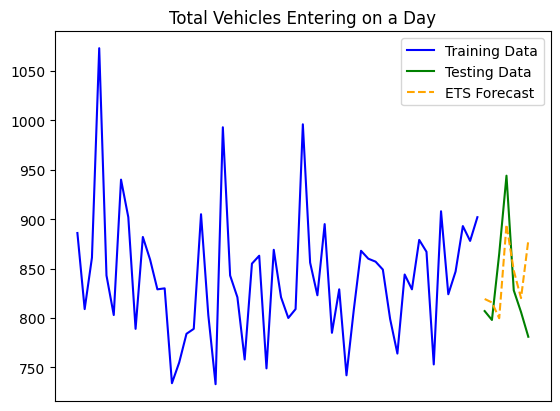


ETS Forecast (Outlier Smoothing Method: deletion)

2024-11-07    819.227152
2024-11-08    815.712797
2024-11-09    799.742573
2024-11-10    894.515001
2024-11-11    848.029039
2024-11-12    820.105377
2024-11-13    878.414833
Freq: D, dtype: float64

ETS MASE: 0.554
ETS MAPE: 4.738



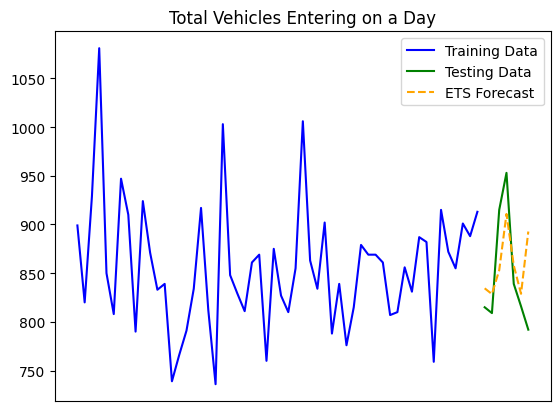


ETS Forecast (Outlier Smoothing Method: LOCF)

2024-11-07    834.453926
2024-11-08    828.542247
2024-11-09    853.036145
2024-11-10    910.808227
2024-11-11    857.974209
2024-11-12    828.801978
2024-11-13    892.745168
Freq: D, dtype: float64

ETS MASE: 0.570
ETS MAPE: 4.650



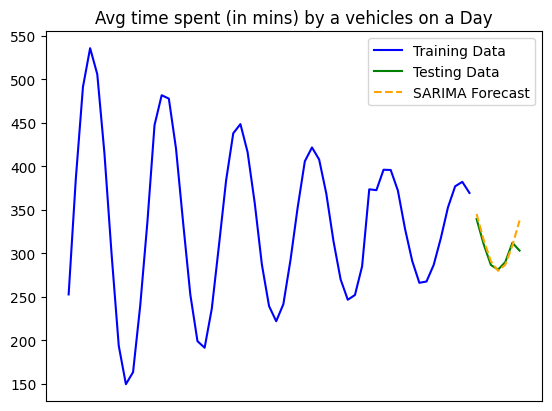


SARIMA Forecast (Outlier Smoothing Method: deletion)

2024-11-08    345.107888
2024-11-09    315.025862
2024-11-10    290.669934
2024-11-11    279.737827
2024-11-12    286.781813
2024-11-13    308.712178
2024-11-14    337.614390
Freq: D, dtype: float64

SARIMA MASE: 0.179
SARIMA MAPE: 2.688



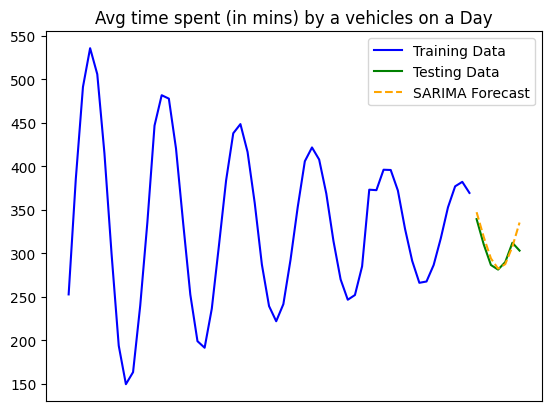


SARIMA Forecast (Outlier Smoothing Method: LOCF)

2024-11-08    347.217387
2024-11-09    318.519326
2024-11-10    293.960554
2024-11-11    282.235101
2024-11-12    287.430327
2024-11-13    307.551203
2024-11-14    335.293148
Freq: D, dtype: float64

SARIMA MASE: 0.200
SARIMA MAPE: 2.997



In [23]:
forecast_total(data, 'deletion')
forecast_total(data, 'LOCF')
forecast_avg(data, 'deletion')
forecast_avg(data, 'LOCF')